## CS410 Fall 2022 Team project - Flagging COVID Disinformation - Notebook A
Team members: David Burrus, Ginna Woo, Jianci Zhai
#### Summary of project: 
This project, as proposed, includes these steps:
1. Screen scrape search results from an arbitrary (but COVID-related) user query. For the purposes of this project, focus on text so-called "organic" search results, and exclude paid search results, images, and videos.
2. For each item returned by the search engine, examine the title, URL, and snippet text. The URL provides direct context by indicating an affiliation.
3. Navigate to each URL returned by the search engine and collect relevant text data, including headings, body, and outlinks. If possible, identify contextual information such as author. Heading and body text from the URL provide a larger "document" for text mining than title and snippet information from the search engine results.
4. Incorporate judgments from "authorities" who are publicly recognized for providing reliable and transparent assessments of information accuracy. Employ such judgments to establish what "accurate information" and "disinformation" look like. This is analogous to using a Cranfield or TREC dataset to identify "relevant" and "non-relevant" query results.
5. Analyze the above text and context data to identify rules for flagging "accurate information" and "disinformation". Such analyses may include topic mining, sentiment analysis, clustering or classification. 
6. Display search engine results with an additional flag or icon indicating level of accuracy or disinformation, so that users are able to make a more informed judgment about which search engine results to explore

In [1]:
# Python libraries for dataframe and math functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# library to set path to data files
import os
# library to extract separate components of a URL
import tldextract
# libraries to retrieve and parse web pages
import requests
from bs4 import BeautifulSoup
import urllib
from requests_html import HTMLSession
# libraries for text cleaning and analysis
import string
import nltk
import collections
from sklearn.feature_extraction.text import TfidfVectorizer

#### Section 1: Scrape search results
This task proved to be much more challenging than expected, for three reasons:
1. Search engines incorporate defensive measures to make scraping difficult. As a consequence, a search engine can return different results when the same search query is repeated. Also some tag contents, while clearly visible during inspection of the search results, proved difficult to access. 
2. Google recently added countermeasures that remove most disinformation from search results related to COVID. This made it difficult to collect a diverse data set as originally planned. Through experimentation, we found that Bing and Yahoo have few or no such countermeasures. To collect training and test data, we therefore attempted to collect data from multiple search engines.
3. Search engines typically return approximately ten organic results per page. Collecting data from multiple search engine pages (e.g., 200 results from the first 20 search result pages) proved much more complex than expected.

Nevertheless, we include some of the code used to scrape search engine results, as proof of concept and to show our commitment to the original project scope.

In [2]:
# function to retrieve and return search engine results from Google -----------------------------------------------------
def get_google_results(query):
    # user agent to avoid being blocked by search engine - see https://deviceatlas.com/blog/list-of-user-agent-strings
    USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    # search engine query string
    url_engine = 'https://google.com/search?q='
    # CSS selector strings
    css_ids = {
         'list': 'search',      # Google list of search results begins with <div id="search">
         'result': '.tF2Cxc',   # each Google search result begins with <div class="tF2Cxc">
         'title': 'h3',         # Google titles begin with <h3 class="LC20lb MBeuO DKV0Md">
         'link': '.yuRUbf a',   # Google links begin with <div class="yuRUbf" original_target=
         'snippet': '.VwiC3b',  # Google snippets begin with <div class="VwiC3b yXK7lf MUxGbd yDYNvb lyLwlc lEBKkf"
         'next': 'a[href][aria-label="Page {page}"]'
    }
    query = urllib.parse.quote_plus(query)   # encodes the query
    try:
        session = HTMLSession()   # TODO - re-implement headers so Google will return what is asked
        session.headers['User-Agent'] = USER_AGENT
        response = session.get(url_engine + query)   
    except requests.exceptions.RequestException as e:
        print(e)   
 
    output = []
    for result in response.html.find(css_ids.get('result')):
        item = {
            'title': result.find(css_ids.get('title'), first=True).text,
            'link':  result.find(css_ids.get('link'), first=True).attrs['href'],
            'snippet':  result.find(css_ids.get('snippet'), first=True).text
        }
        output.append(item)
    return output


# function to retrieve and return search engine results from Bing -------------------------------------------------------
def get_bing_results(query):
    # user agent to avoid being blocked by search engine - see https://deviceatlas.com/blog/list-of-user-agent-strings
    USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    headers = { 'User-Agent': USER_AGENT }
    # search engine query string
    url_engine = 'https://www.bing.com/search?q='
    # CSS selector strings
    css_ids = {
         'list': 'ol',              # Bing list of search results begins with <ol id="b_results" class="">
         'result': '.b_algo',       # each Bing search results begins with <li class="b_algo" data-bm="8">
         'title': '.b_algo h2 a',   # Bing titles are under <h2>
         'link': '.b_caption cite', # Bing links are under <div class="b_attribution" ... <cite>
         'snippet': '#b_results p', # Bing snippets begin with <p class=" b_lineclamp2">
         'next': 'div#b_content nav[role="navigation"] a.sb_pagN'
    }
    html = requests.get(url_engine + query, headers=headers).text
    soup = BeautifulSoup(html, 'lxml')
    output = []
    for result in soup.select(css_ids.get('result')):
        try:
            title = result.select_one(css_ids.get('title')).text
        except:
            title = None
        try:
            link = result.select_one(css_ids.get('link')).text
        except:
            link = None
        try:
            snippet = result.select_one(css_ids.get('snippet')).text
        except:
            snippet = None
        item = {
            'title': title,
            'link':  link,
            'snippet': snippet
        }
        output.append(item)
    return output


# function to retrieve and return search engine results from Yahoo ------------------------------------------------------
def get_yahoo_results(query):
    # user agent to avoid being blocked by search engine - see https://deviceatlas.com/blog/list-of-user-agent-strings
    USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.19582'
    headers = { "User-Agent": USER_AGENT }
    # search engine query string
    url_engine = 'https://search.yahoo.com/search?q='
    # CSS selector strings
    css_ids = {
         'list': 'main',
         'result': 'div#web li div.dd.algo.algo-sr', 
         'title': 'div.compTitle h3.title a',     # TODO - does not separate link from title
         'link': 'div.compTitle h3.title span',   # TODO - link contains > instead / 
         'snippet': 'div.compText span.fc-falcon',
         'next': 'div#b_content nav[role="navigation"] a.sb_pagN'
    }
    html = requests.get(url_engine + query, headers=headers).text
    soup = BeautifulSoup(html, 'lxml')
    output = []
    for result in soup.select(css_ids.get('result')):
        try:
            title = result.select_one(css_ids.get('title')).text
        except:
            title = None
        try:
            link = result.select_one(css_ids.get('link')).text
            link = link.replace(' › ','/')
            # link = result.select_one(css_ids.get('link'))['original_target'],
        except:
            link = None
        try:
            snippet = result.select_one(css_ids.get('snippet')).text
        except:
            snippet = None
        item = {
            'title': title,
            'link':  link,
            'snippet': snippet
        }
        output.append(item)
    return output


# code for testing the above functions ----------------------------------------------------------------------------------

# set dataframe display parameters to show all columns and more text
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 160)

# sample queries for testing, already formatted with plus between words
qry_autism = 'covid+vaccines+cause+autism'
qry_weapon = 'covid+is+a+biological+weapon'
qry_immune = 'covid+boosters+hurt+immune+system'
qry_covax  = 'covid+vaccine'
# prefix necessary to restrict search engine to a particular URL
site_prefix = '+site%3A'
# sites widely judged to be sources of COVID disinformation
site_childrens = 'childrenshealthdefense.org'
site_mercola   = 'mercola.com'
site_greenmed  = 'greenmedinfo.com'
# sites widely judged to be data-driven with regard to COVID
site_cdc = 'cdc.gov'  # Centers for Disease Control
site_nih = 'nih.gov'  # National Institutes of Health
site_who = 'who.int'  # World Health Organization

# build 'query' for testing, using different combinations of the above strings
# query = qry_autism + site_prefix + site_childrens
query = qry_covax

# retrieve and print first page of search results from Bing
results = get_bing_results(query)  # this works
print('\nBING results from', query, ' ---------------------------\n')
bing_df = pd.DataFrame.from_dict(results)
print(bing_df)

# retrieve and print first page of search results from Google
results = get_google_results(query)  # this works
print('\nGOOGLE results from', query, ' -------------------------\n')
google_df = pd.DataFrame.from_dict(results)
print(google_df)

# get search results from Yahoo
results = get_yahoo_results(query)  # this works
print('\nYAHOO results from', query, ' -------------------------\n')
df = pd.DataFrame.from_dict(results)
print(df)


BING results from covid+vaccine  ---------------------------

                                                           title  \
0                                    Vaccines for COVID-19 | CDC   
1        Vaccines.gov - Find COVID‑19 vaccine locations near you   
2                                   COVID-19 vaccine - Wikipedia   
3                       COVID-19 Bivalent Vaccine Boosters | FDA   
4  Pfizer/BioNTech seek FDA authorization for updated Covid-19 …   
5          COVID-19 Vaccine & Information - South Shore Hospital   
6          New COVID Boosters: What We Know About Them and Who …   
7                                    COVID-19 Vaccines | HHS.gov   
8    Is Covid-19 vaccine causing increase in heart attack cases?   

                                                                            link  \
0                             https://www.cdc.gov/coronavirus/2019-ncov/vaccines   
1                                                       https://www.vaccines.gov   
2   

#### Section 2: Collect text, context, and judgment data
Due to the challenges of search engine scraping, the project team eventually had to collect data manually, as follows:
1. <b>covid_search_results_summary.xls</b> includes 'link' (the URL for each search engine result) and 'content' (text from that search engine result page) for 242 web pages that were returned by COVID-related queries. 
2. One team member read all 242 of the documents in the data set and added her judgment about level of disinformation, from 1 (very likely disinformation) to 5 (very likely accurate information).
3. Each document's URL has a top-level domain (TLD) or 'suffix' such as edu, gov, com, net, and so on. Data suggest that, in general, information published by academic institutions (edu), government agencies (gov), and non-profits (org) tends to be more reliable and accurate than information from certain other TLDs (e.g., info, news, ph), perhaps because academic and government papers typically are highly scrutinized and therefore evidence-based. 
4. <b>url_accuracy.xls</b> contains 3,442 ratings of factual accuracy and political bias from "authorities" as described above. These ratings are tied to <u>organization and URL</u> rather than to individual documents. As such, these ratings can be considered as a kind of reputation based on many, many documents published by each organization. Numerous fact-checking organizations exist worldwide; a partial list may be found at https://reporterslab.org/fact-checking/, among other places. However, the majority of such fact-checking is <u>document-specific</u>. As disinformation providers evolve and adapt, documents from, say, early 2020 may be no longer a good reference point. Therefore the team opted to use judgments that are more broadly applicable. Accuracy ratings from independent fact-checkers, from 'very low' to 'very high', are available for approximately 65% of the documents in the full data set. These ratings will help us generate training data.
5. For code testing purposes only, a smaller data set was extracted from covid_search_results_summary.xls and saved as <b>covid_search_results_sample.xls</b>. This data set contains 25 records with the most text data, comprising 11% of records but 34% of words in the full data set (approximately 98,000 of 291,000 words total).

In [3]:
# load "search engine result pages" (serp) into dataframe ---------------------------------------------------------------
# change 'path' as needed to match file location within Jupyter notebook
print('\nReading data files ...')
path = 'C:/Users/David/Documents/Python/CS410_Team_Project'
os.chdir(path)
# serp_file = 'covid_search_results_sample.xls'      # development data set - 25 records with ~33% of words in collection
# serp_file = 'covid_search_results_summary_A.xlsx'  # full data set without dummy entries 
serp_file = 'covid_search_results_summary.xls'     # full data file with 'the the' dummy entries at end
serp_df = pd.read_excel(serp_file).dropna()
# serp_file contains these columns:
# 'doc_id', = consecutive reference number, starting at 1
# 'content' = text content copied and pasted from web page
# 'link' = URL of web page that provided 'content'
# 'given by user1' = opinion of one user, from 1 (disinformation) to 5 (accurate). Renamed below.
# 'len' = character length of content, up to Excel's maximum of 32767. Not used.
serp_df.rename(columns={'given by user1': 'user1_judgment'}, inplace=True)
serp_df.drop(['len'], axis=1, inplace=True)
# remove ~12 dummy entries used by Notebook B
serp_df = serp_df[serp_df.link != 'https://www.abcnews.go.com/dummy-content/']  

# load url ratings from independent fact-checkers into dataframe columns ------------------------------------------------
# 'host' = website being judged
# 'bias' = political left, right, satire, pro-science, ...
# 'accuracy' = factual accuracy from 'very low' to 'very high'
# 'source' = URL describing basis for judgment
rating_file = 'url_accuracy.xls'
rating_df = pd.read_excel(rating_file)


# function to retrieve and clean headings and outlinks from each search engine result page ------------------------------
def load_tags(serp_link):
    # initialize variables to temporarily store on-page headers and outlinks
    link_dict = collections.defaultdict(int)
    link_list = []
    tag_list = ['h1', 'h2', 'a']
    h1_text = ''
    h2_text = ''
    string.punctuation = string.punctuation + '‘’“”'

    print('  ', serp_link)
    # try-except block to handle web page time outs and similar issues.
    try:
        req = requests.get(serp_link, timeout=2)
        soup = BeautifulSoup(req.text, 'lxml')
        # retrieve headers and outlinks from the search engine result page
        for tags in soup.find_all(tag_list):
            # build a separate list for each header level found
            if tags.name == 'h1':
                h1_text += tags.text.strip().lower().\
                    translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
            elif tags.name == 'h2':
                h2_text += tags.text.strip().lower().\
                    translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
            # build a dictionary with a count of each unique top-level link found
            elif tags.name == 'a':
                this_href = tags.get('href')
                if this_href != None:
                    tld = tldextract.extract(this_href)
                    link_dict['.'.join(tld[1:]).lower()] += 1
        # remove too-short links and sort by descending frequency
        link_list = sorted(link_dict.items(), key=lambda elem: elem[1], reverse=True)
        link_list = [elem for elem in link_list if len(elem[0]) > 3]
    except Exception as e:
        print(e)
    return h1_text, h2_text, link_list

# add dataframe columns containing headers and outlinks
print('\nCollecting headings and links from ...')
serp_df['tags'] = serp_df.apply(lambda x: load_tags(x['link']), axis=1)
h1_text, h2_text, link_list = zip(*serp_df['tags'])
serp_df['h1_hdrs'] = h1_text
serp_df['h2_hdrs'] = h2_text
serp_df['outlinks'] = link_list
serp_df.drop(['tags'], axis=1, inplace=True)



Reading data files ...

   https://www.hopkinsmedicine.org/health/conditions-and-diseases/coronavirus/covid-natural-immunity-what-you-need-to-know
   https://www.cdc.gov/coronavirus/2019-ncov/science/science-briefs/vaccine-induced-immunity.html
   https://catalyst.phrma.org/word-of-the-month-what-is-long-covid?utm_campaign=2022-q4-cov-inn&utm_medium=pai_srh_cpc-ggl-adf&utm_source=ggl&utm_content=clk-pat-tpv_scl-geo_std-usa-all-pai_srh_cpc-ggl-adf-LongCOVIDNationalSearch2-cov_uns-edu-inf-lrm-soc_txt-std-vrb-adf&utm_term=&gclid=Cj0KCQjwk5ibBhDqARIsACzmgLTkQ6GXCU95b67YJu_NOFijkSQEQQM8s8mr2Ky6FjXLIKdqPaCmI8MaAtjrEALw_wcB
   https://www.bloomberg.com/news/articles/2021-08-27/previous-covid-prevents-delta-infection-better-than-pfizer-shot
   https://medicine.iu.edu/news/2020/05/researchers-launch-statewide-covid-19-immunity-study
   https://www.theguardian.com/world/2020/jul/12/immunity-to-covid-19-could-be-lost-in-months-uk-study-suggests
   https://jamanetwork.com/journals/jamanetworkopen

C:\ProgramData\Anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


   https://medicalxpress.com/news/2022-11-previous-covid-infection-subvariant-due.html
   https://airpurifiers.com/best-air-purifiers/articles-cleaning-tips-for-your-office-to-prevent-coronavirus-2.html
   https://www.smithsonianmag.com/innovation/homemade-air-purifier-thats-been-saving-lives-during-covid-19-pandemic-180979681/
   https://www.newstarget.com/2020-09-09-cdc-fema-camps-hold-children-covid-19.html
   https://www.bia.gov/covid-19/federal-response-resources
   https://www.bitchute.com/video/pyczBzMfOnuo/
   https://www.bitchute.com/video/i2fMnrMH3Zm3/
   https://www.bitchute.com/video/9IbspR8lpNR9/
   https://www.brighteon.com/ff9913f3-0123-40ad-9206-504083bba81f
   https://www.brighteon.com/14e71e41-2eca-439b-9e79-765fa071d5b2
   https://nworeport.me/2022/11/09/watch-vaxxedtothemax-canadian-lawyer-suddenly-collapses-during-inquiry/
   https://www.ayurvedicindia.info/antiviral-herbs-that-will-help-against-the-corona-virus/
   https://www.ibtimes.com/these-herbal-medicines-pr

   https://www.organicconsumers.org/blog/planet-coronavirus-survival-resistance-and-regeneration
   https://www.commondreams.org/news/2021/05/14/revealed-big-pharmas-plot-derail-us-covid-19-vaccine-waiver
   https://eand.co/this-is-why-big-pharma-doesnt-want-covid-to-end-e3a44280015f
   https://www.rollingstone.com/politics/politics-features/big-pharma-covid-19-profits-1041185/
   https://www.fastcompany.com/90665473/big-pharma-green-covid-19-vaccines-ip-greed
   https://www.thelibertybeacon.com/big-pharma-profits-from-c19-vvv-and-treatments-reaping-billion-in-sales/
   https://www.thelibertybeacon.com/a-slap-in-the-pface-big-pharma-ceo-c19-will-be-a-multi-billion-franchise-for-years-to-come/
   https://www.dailymail.co.uk/news/article-8529269/Daily-death-toll-INFLATED-fewer-40-people-dying-day-UK.html
   https://khn.org/news/article/cdc-senior-covid-vaccination-rates-appear-inflated/
   https://www.washingtonexaminer.com/politics/house-report-says-floridas-covid-19-death-toll-inflated


Adding contexts to dataframe ...

Document count by team judgment:
 4.0    64
1.0    47
3.0    46
2.0    46
5.0    39
Name: user1_judgment, dtype: int64

Document count by expert judgment:
 high              69
mixed             38
very high         16
very low          14
low               12
mostly factual    10
Name: accuracy, dtype: int64

Document count by top-level domain:
 com       157
org        41
gov        10
co.uk       9
edu         8
ph          3
co          3
ca          2
net         2
eu          1
me          1
info        1
int         1
in          1
org.nz      1
io          1
Name: suffix, dtype: int64


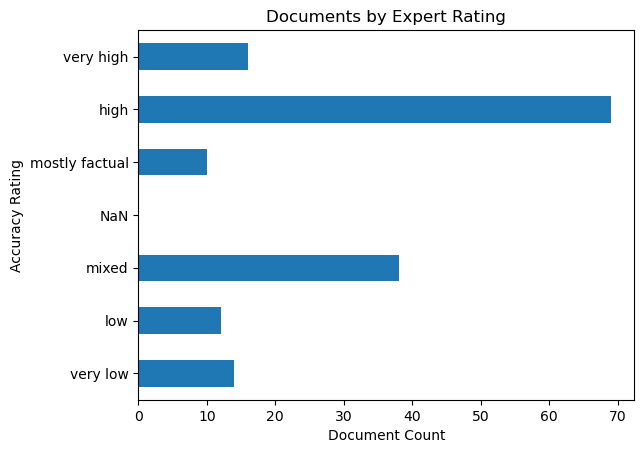

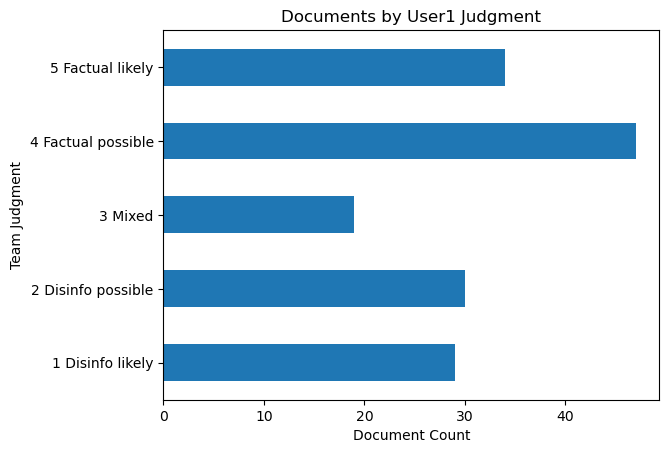

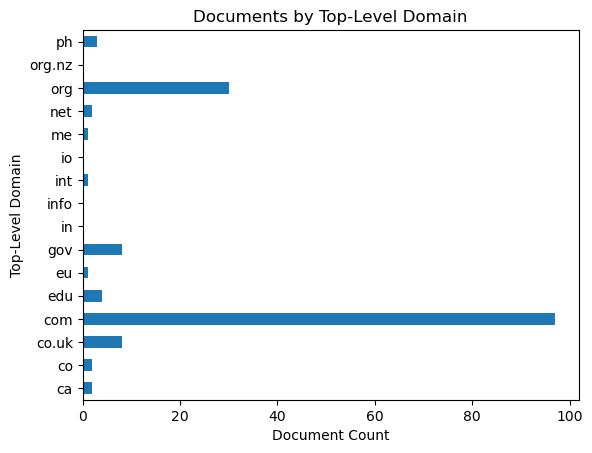

In [4]:
# combine data from various sources into one dataframe ------------------------------------------------------------------

# add dataframe columns containing URL components of search result link. Subdomain is not used.
# suffix (a.k.a. top-level domain, e.g., edu, gov, com, ...) is retained as a separate column
# based on the prior belief that edu and gov sites are morelikely to have evidence-based information
# create new dataframe with word frequencies by top-level domain (edu, com, gov, ...)

# serp_df['subdomain'] = serp_df['link'].apply(lambda url: tldextract.extract(url).subdomain)
print('\nAdding contexts to dataframe ...')
serp_df['domain'] = serp_df['link'].apply(lambda url: tldextract.extract(url).domain)
serp_df['suffix'] = serp_df['link'].apply(lambda url: tldextract.extract(url).suffix)
serp_df['host'] = serp_df['domain'] + '.' + serp_df['suffix']

# add dataframe columns containing expert judgments based on serp host
serp_df = serp_df.merge(rating_df, on=['host'], how='left')
serp_df.drop(['source'], axis=1, inplace=True)
# map accuracy to ordinal values and a categorical variable for later analysis
serp_df['accuracy_code'] = serp_df['accuracy'].map({'very low':-5, 'low':-3, 
            'mixed':-1, '':0, 'mostly factual':1, 'high':3, 'very high':5}).fillna(0)
serp_df['accuracy_cat'] = serp_df['accuracy'].astype('category')

# display some exploratory analysis -------------------------------------------------------------------------------------

print('\nDocument count by team judgment:\n', serp_df['user1_judgment'].value_counts())
print('\nDocument count by expert judgment:\n', serp_df['accuracy'].value_counts())
print('\nDocument count by top-level domain:\n', serp_df['suffix'].value_counts())

serp_df.groupby(['accuracy_code'])['accuracy'].count().plot(kind = 'barh')
plt.title('Documents by Expert Rating')
plt.ylabel('Accuracy Rating')
plt.xlabel('Document Count')
plt.yticks(range(7), ('very low', 'low', 'mixed', 'NaN', 'mostly factual', 'high', 'very high'))
plt.show()

serp_df.groupby(['user1_judgment'])['accuracy'].count().plot(kind = 'barh')
plt.title('Documents by User1 Judgment')
plt.ylabel('Team Judgment')
plt.xlabel('Document Count')
plt.yticks(range(5), ('1 Disinfo likely', '2 Disinfo possible', '3 Mixed', '4 Factual possible', '5 Factual likely'))
plt.show()

serp_df.groupby(['suffix'])['accuracy'].count().plot(kind = 'barh')
plt.title('Documents by Top-Level Domain')
plt.ylabel('Top-Level Domain')
plt.xlabel('Document Count')
plt.show()

#### Section 3: Sentiment analysis
This code uses NLTK's built-in "VADER" "sentiment analysis to generate for each row the probabilities for 'positive', 'neutral', and 'negative' sentiment. VADER also generates a 'compound' score of sentiment intensity, where a value ≥ 0.05 indicates positive sentiment, ≤ -0.05 indicates negative sentiment, and values between -0.05 and +0.05 (exclusive) indicate neutral sentiment.

In [5]:
# add dataframe columns for sentiment analysis --------------------------------------------------------------------------
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = nltk.sentiment.SentimentIntensityAnalyzer()

serp_df['polarity_scores'] = serp_df['content'].apply(sia.polarity_scores)
serp_df['sentiment_neg'] = serp_df['polarity_scores'].apply(lambda x: x['neg'])
serp_df['sentiment_neu'] = serp_df['polarity_scores'].apply(lambda x: x['neu'])
serp_df['sentiment_pos'] = serp_df['polarity_scores'].apply(lambda x: x['pos'])
serp_df['sentiment_compound'] = serp_df['polarity_scores'].apply(lambda x: x['compound'])
serp_df.drop(['polarity_scores'], axis=1, inplace=True)

print('\nDimensions of SERP dataframe:', serp_df.shape)
print('\nColumns in SERP dataframe:\n', serp_df.columns)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Dimensions of SERP dataframe: (242, 19)

Columns in SERP dataframe:
 Index(['doc_id', 'content', 'link', 'user1_judgment', 'h1_hdrs', 'h2_hdrs',
       'outlinks', 'domain', 'suffix', 'host', 'bias', 'accuracy',
       'accuracy_score', 'accuracy_code', 'accuracy_cat', 'sentiment_neg',
       'sentiment_neu', 'sentiment_pos', 'sentiment_compound'],
      dtype='object')


#### Section 4: Pre-process text data
This code uses NLTK to:
1. Tokenize the 'content' column. This includes removal of standard and unusual punctuation, numbers, and stop words. 
2. Create a separate list of stems. This reduces the number of unique words, but stemming results can be difficult to interpret (e.g., 'caring' can stem to 'car').
3. Create a separate list of lemmas. Lemmatization produces a slightly longer list of words than stemming, but those words are easier to understand in later analyses.
4. Create separate frequency distributions for the content tokens, lemmas, and stems. All three are retained at this stage of the project to determine which will be more useful in subsequent analysis. The frequency distribution plots all show an 'elbow', suggesting that words like 'vaccine', 'people', and 'covid' are common throughout the collection, so TF-IDF could be helpful. However, one also can see some possible discrimative words, such as 'health', 'supplement', 'infection', and 'data'.


Tokenizing content ...
This may take a few minutes for the entire corpus.

Tokenizing headers ...

Plotting word frequencies for collection ...


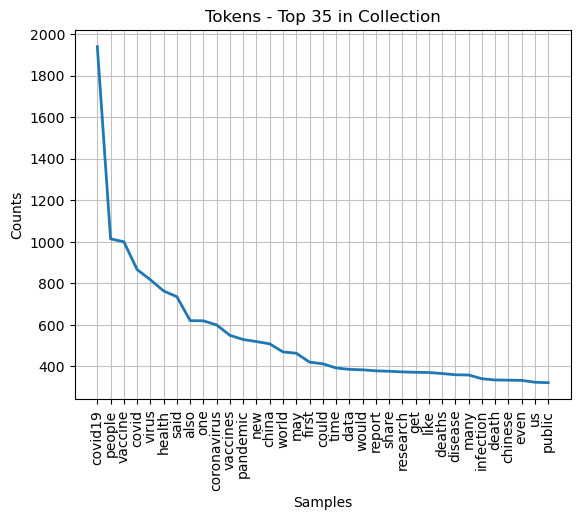

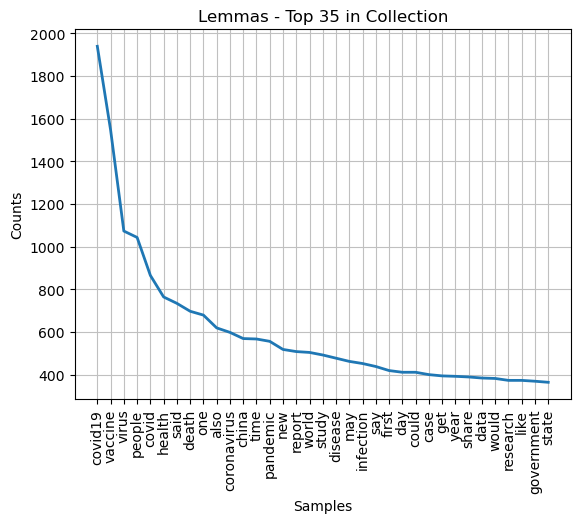

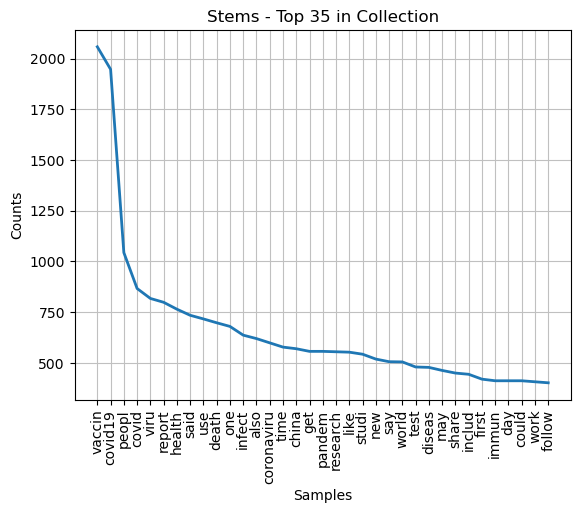

<AxesSubplot:title={'center':'Stems - Top 35 in Collection'}, xlabel='Samples', ylabel='Counts'>

In [6]:
# function to clean and tokenize document text --------------------------------------------------------------------------
# returns three strings: words as found, lemmatized words, and stemmed words 
# so that we can determine which will be most helpful in later analysis
def process_text(serp_content):
    token_list = nltk.word_tokenize(serp_content)
    # remove punctuation marks and lowercase all words
    token_list = [tok.lower() for tok in token_list if tok not in string.punctuation]
    # remove any stop words
    token_list = [word for word in token_list 
                  if word not in nltk.corpus.stopwords.words('english')]
    # remove any numbers, since their meaning is lost without context
    token_list = [tok for tok in token_list if not tok.isnumeric()]
    # remove any remaining short strings e.g., special punctuation, single letters
    token_list = [tok for tok in token_list if not len(tok) < 3]
    # perform lemmatization and Porter stemming before calculating frequencies
    lemma_list = []
    stem_list = []
    for word in token_list:
        lemma_list.append(nltk.stem.WordNetLemmatizer().lemmatize(word))
        stem_list.append(nltk.stem.PorterStemmer().stem(word))
    # combine token into a single string for subsequent processing
    # remove any punctuation still embedded in tokens (hyphens, single quotes, etc.)
    token_text = ' '.join(token_list).translate(str.maketrans('', '', string.punctuation))
    lemma_text = ' '.join(lemma_list).translate(str.maketrans('', '', string.punctuation))
    stem_text = ' '.join(stem_list).translate(str.maketrans('', '', string.punctuation))
    return token_text, lemma_text, stem_text


# add data columns containing strings of tokens, lemmas, and stems ------------------------------------------------------
print('\nTokenizing content ...')
print('This may take a few minutes for the entire corpus.')
# remove any non-ascii characters (e.g., unicode, emoticons) prior to tokenizing
serp_df['content'] = serp_df['content'].str.encode('ascii', 'ignore').str.decode('ascii')
# add dataframe columns containing tokenized original words, lemmas, and stems
serp_df['processed_content'] = serp_df.apply(lambda x: process_text(x['content']), axis=1)
token_text, lemma_text, stem_text = zip(*serp_df['processed_content'])
serp_df['token_text'] = token_text
serp_df['lemma_text'] = lemma_text
serp_df['stem_text'] = stem_text
serp_df.drop(['processed_content'], axis=1, inplace=True)

print('\nTokenizing headers ...')
serp_df['h1_hdrs'] = serp_df['h1_hdrs'].str.encode('ascii', 'ignore').str.decode('ascii')
serp_df['processed_content'] = serp_df.apply(lambda x: process_text(x['h1_hdrs']), axis=1)
token_text, lemma_text, stem_text = zip(*serp_df['processed_content'])
serp_df['token_hdrs'] = token_text
serp_df['lemma_hdrs'] = lemma_text
serp_df['stem_hdrs'] = stem_text
serp_df.drop(['processed_content'], axis=1, inplace=True)

serp_df['h2_hdrs'] = serp_df['h2_hdrs'].str.encode('ascii', 'ignore').str.decode('ascii')
serp_df['processed_content'] = serp_df.apply(lambda x: process_text(x['h2_hdrs']), axis=1)
token_text, lemma_text, stem_text = zip(*serp_df['processed_content'])
serp_df['token_hdrs'] = serp_df['token_hdrs'] + " " + token_text
serp_df['lemma_hdrs'] = serp_df['lemma_hdrs'] + " " + lemma_text
serp_df['stem_hdrs'] = serp_df['stem_hdrs'] + " " + stem_text
serp_df.drop(['processed_content'], axis=1, inplace=True)

# create frequency distribution objects to find most common words in collection -----------------------------------------
print('\nPlotting word frequencies for collection ...')
token_list = []
lemma_list = []
stem_list = []
for index, row in serp_df.iterrows():
    token_list.extend(row['token_text'].split())
    lemma_list.extend(row['lemma_text'].split())
    stem_list.extend(row['stem_text'].split())
freq_dist_tokens = nltk.FreqDist(token_list)
freq_dist_lemmas = nltk.FreqDist(lemma_list)
freq_dist_stems = nltk.FreqDist(stem_list)

# plot most common words, lemmas, and stems as line charts --------------------------------------------------------------
freq_dist_tokens.plot(35, title='Tokens - Top 35 in Collection')
freq_dist_lemmas.plot(35, title='Lemmas - Top 35 in Collection')
freq_dist_stems.plot(35, title='Stems - Top 35 in Collection')

##### Commentary:
The above plots show an inflection point or "elbow". Terms like 'covid-19', 'virus', 'vaccine', and 'people' are extremely common. These words may be common in both information and disinformation, in which case they would be poor discriminators. IDF (Inverse Document Frequency) weighting may overcome this issue.

#### Section 5: Prepare data
This code vectorizes body text and header text for each document, creates dummy variables for each categorical variable, and combines all features into one dataframe.

Experimentation revealed with various combinations of variables revealed that:
1. Stems tended to generate higher precision and recall than lemmas or tokens.
2. Sentiment analysis did not improve precision or recall, so it was excluded from the final model.
3. Top-Level Domain ('suffix') did not improve precision or recall, so it was excluded from the final model.
4. Reducing the number of features did improve recall, with a total of 100 features (50 from content and 50 from headers) producing the best results.

In [7]:
# create a sparse matrix of values for term frequency x inverse document frequency --------------------------------------
print('\nPreparing data for training and testing ...')

# for training and testing purposes, use only rows that contain a matching expert judgment
serp_match_df = serp_df[serp_df['accuracy'].notna()].copy()
# serp_match_df.reset_index()
# serp_match_df = serp_df.copy()

# using sublinear term frequency, inverse-document-frequency reweighting, and smoothing:
# vectorize each document's content (body text), starting with a small subset of possible features
vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True, max_features=30)
stem_matrix = vectorizer.fit_transform(serp_match_df['stem_text'])
content_df = pd.DataFrame(stem_matrix.toarray())
# label each column with the word it represents
content_df.columns = vectorizer.get_feature_names_out()

# vectorize each document's header text 
header_matrix = vectorizer.fit_transform(serp_match_df['stem_hdrs'])
header_df = pd.DataFrame(header_matrix.toarray())
# label each column with the word it represents plus 'hdr' to indicate its origin
header_df.columns = vectorizer.get_feature_names_out() +  '_hdr'

# convert top-level domain 'suffix' categorical variable into dummy variables
suffix_df = pd.get_dummies(serp_match_df['suffix'])
# label each column with '_tld' to column names to indicate its origin
suffix_df = suffix_df.add_suffix('_tld')

# copy sentiment columns for possible use in model
sentiment_df = serp_match_df[['sentiment_neg', 'sentiment_pos', 'sentiment_neu', 'sentiment_compound']].copy()

# combine all features into a single dataframe and identify the dependent (label) variable
# experimentation with different sets of features demonstrated that model accuracy was reduced 
# by including sentiment or top-level domain (suffix). Fewer than 25 features or more than 100 features 
# also reduced model accuracy.
# feature_df = pd.concat([serp_df, accuracy_df, suffix_df, content_df, header_df], axis=1, join="outer")
# feature_df = pd.concat([suffix_df.reset_index(), content_df, header_df], axis=1, join="outer")
# feature_df = pd.concat([sentiment_df.reset_index(), content_df, header_df], axis=1, join="outer")
feature_df = pd.concat([content_df, header_df], axis=1, join="outer")   # max_features = 30
label_df = serp_match_df['accuracy_cat']

# display what we have 
print('\nSERP dataframe:\n', serp_df.head())
print('\nFeature dataframe:\n', feature_df.head())
print('\nLabel dataframe:\n', label_df.head())
print('\nSERP dimensions:\n', serp_df.shape)
print('\nFeature dimensions:\n', feature_df.shape)
print('\nLabel dimensions:\n', label_df.shape)


Preparing data for training and testing ...

SERP dataframe:
    doc_id  \
0       1   
1       2   
2       3   
3       4   
4       5   

                                                                                                                                                           content  \
0  COVID Natural Immunity: What You Need to Know\nShare on Facebook Share on Twitter Share on Linkedin Share on Pinterest Share via Email Print this Page\nFeat...   
1  Science Brief: SARS-CoV-2 Infection-induced and Vaccine-induced Immunity\nUpdated Oct. 29, 2021\nPrint\nCOVID-19 Science Briefs provide a summary of the sci...   
2  Word of the Month: Long COVID\nMike Ybarra\nMike Ybarra\nOctober 19, 2022\n\nWord of the Month: Long COVID.\nShare This\nWhat is Long COVID?\n\nLong COVID, ...   
3  Previous Covid Prevents Delta Infection Better Than Pfizer Shot\nEarly data from Israel shows natural immunity wanes with time\nPeople who recovered from Co...   
4  IU School of Medicine res

#### Section 6: Build classifier model (Support Vector Machine)
This project requires predetermined "topics" or categories. At a minimum, there are three categories: disinformation, accurate information, and an in-between group that could be labeled as "mixed" or "undetermined". To assist users further, the team chose a five-point scale: 1 (very likely disinformation), 2 (likely disinformation), 3 (mixed/undetermined), 4 (likely accurate), and 5 (very likely accurate). 

Therefore we investigated text classification techniques and checked existing research for recommendations.
1. Naïve Bayes is reported to work well when classifying "fake news" with small datasets, as is the case for our project (n=236). However, Naïve Bayes does not perform well if words are co-related with each other, which certainly appears true for our dataset.
2. Logistic Regression performs well in binary classification, e.g., "disinfo" vs. "good info", but as mentioned our project intends to show users more than two categories.
3. K-Nearest Neighbors reputedly is robust with noisy data (which we appear to have), but the number of potential dimensions (e.g., more than 20,000 different words in the dataset) may need to be pruned substantially.
4. Support Vector Machine has been well researched and offers these advantages: 
    1. SVM can handle multiple categories.
    2. SVM is effective in high-dimensional spaces, even when the number of dimensions exceeds the number of samples, as is the case here.
    3. It is tolerant of irrelevant features, which can be important when the text data are "noisy".
    4. Numerous research papers show that SVM performs well in fake news detection -- in some studies, nearly as well as Random Forest and neural networks.

In [8]:
print('\nBuilding classifier model ...')
from sklearn.model_selection import train_test_split
# split dataset into 80% training data and 20% testing data
test_share = 0.2
x_train, x_test, y_train, y_test = train_test_split(
    feature_df, label_df, test_size=test_share,random_state=0) 

from sklearn import svm
# experimentation revealed that models with kernel='poly' tend to have better accuracy than other types
classifier = svm.SVC(kernel='poly', degree=3)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

from sklearn import metrics
# display the classifier's attributes
print('\nNumber of features:', classifier.n_features_in_)
print('Class labels:', classifier.classes_)
print('Number of support vectors for each class:', classifier.n_support_)

# display how often the classifier's answer matches the dependent variable
print(f'\nAccuracy: {metrics.accuracy_score(y_test, y_pred, normalize=False)} of', 
      f'{test_share*len(feature_df):.0f} samples were classified correctly')
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
# display precision = tp / (tp + fp) where tp is the number of true positives and fp the number of false positives
print('Precision:', metrics.precision_score(y_test, y_pred, average='micro'))
# display recall = tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives
print('Recall:   ', metrics.recall_score(y_test, y_pred, average='micro'))
# display F-measure = harmonic mean of precision and recall
print('F1:', metrics.f1_score(y_test, y_pred, average='micro', labels=np.unique(y_pred)))
print('\nComparison of actual vs. predicted ratings:')
pred_comparison = pd.DataFrame(np.array([y_test, y_pred]).T)
pred_comparison.columns = ['y_test','y_pred']
print(pred_comparison, '\n')
print(pred_comparison.groupby(['y_test','y_pred'])['y_pred'].count())


Building classifier model ...

Number of features: 60
Class labels: ['high' 'low' 'mixed' 'mostly factual' 'very high' 'very low']
Number of support vectors for each class: [56  9 30  8 15  9]

Accuracy: 16 of 32 samples were classified correctly
Accuracy:  0.5
Precision: 0.5
Recall:    0.5
F1: 0.5517241379310345

Comparison of actual vs. predicted ratings:
            y_test    y_pred
0             high     mixed
1             high      high
2             high      high
3         very low      high
4              low      high
5             high      high
6             high      high
7              low     mixed
8            mixed     mixed
9         very low      high
10           mixed     mixed
11            high      high
12  mostly factual      high
13        very low     mixed
14           mixed     mixed
15            high     mixed
16        very low      high
17            high      high
18  mostly factual      high
19           mixed      high
20            high      high
2

## Summary
The SVM model's accuracy, precision, recall, and F-measure are lower than hoped. More experienced researchers have obtained results in the 84% to 89% range in various "fake news classification" studies. 

Our much lower results probably are influenced by having only a small dataset (242 records in the Excel file) for training and testing. It would be interesting to train our model using the COVID-19 Open Research Dataset (CORD-19). One possible disadvantage is that CORD-19 contains scientific literature. It does NOT contain any intentional disinformation. To have a robust model, it may be necessary to create a corpus of COVID disinformation, starting from resources such as the 
ESOC COVID-19 Misinformation Dataset maintained by Princeton University, or lists maintained by reputable fact-checking organizations. 